# Lab 3

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, recall_score, precision_score, roc_curve
from sklearn.svm import SVR
%matplotlib inline

Сгенерируем выборку так, чтобы классы не сильно перемешивались и разобьем на train и test в отношении 1:1

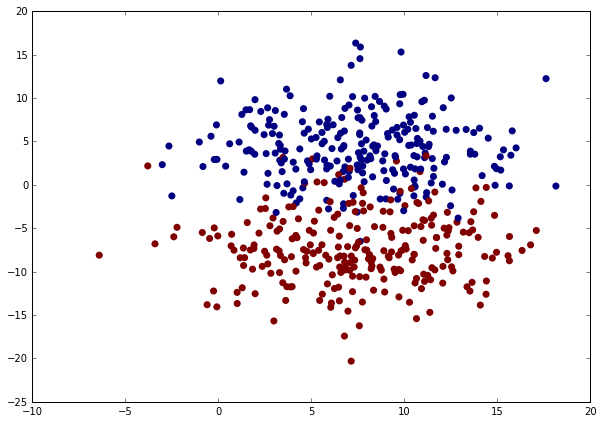

In [254]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=4)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, linewidths=0, s=50)
plt.show()

In [255]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X, y, test_size=0.5, random_state=1234)

## Пункт 1

Обучим LDA, LogisticRegression и SVM на train выборке и получим $w$ и $w_0$:

In [9]:
def get_w_w0(clf, name, X_train, y_train):
    clf.fit(X_train, np.ravel(y_train))

    print "%s w:"%name, clf.coef_
    print "%s w_0:"%name, clf.intercept_
    print

In [10]:
def regressions(lda, lr, svm, X_train, y_train):
    get_w_w0(lda, "LDA", X_train, y_train)
    get_w_w0(lr, "LR", X_train, y_train)
    get_w_w0(svm, "SVM", X_train, y_train)

In [11]:
lda_norm = LinearDiscriminantAnalysis()
lr_norm = LogisticRegression()
svm_norm = LinearSVC()
regressions(lda_norm, lr_norm, svm_norm, X_train_norm, y_train_norm)

LDA w: [[ 0.64855188 -0.32323691]]
LDA w_0: [-2.87391402]

LR w: [[ 0.56143992 -0.35016758]]
LR w_0: [-2.40945505]

SVM w: [[ 0.19498085 -0.11686757]]
SVM w_0: [-0.89551211]



Построим графики recall, precision, mse и f1 в зависимости от w_0:

In [12]:
sign_2 = lambda a: 1 if a > 0 else 0
sign_1 = lambda a: 1 if a >= 0 else 0

In [13]:
def show_graphs(w_0, precision, recall, f1, mse, clf):
    plt.figure(figsize=(14, 6))

    plt.plot([w_0[i/2] for i in range(500)], precision, label="precision")
    plt.plot([w_0[i/2] for i in range(500)], recall, label="recall")
    plt.plot([w_0[i/2] for i in range(500)], f1, label="f1")
    plt.plot([w_0[i/2] for i in range(500)], mse, label="mse")

    plt.xlabel('w_0')
    plt.ylabel('%s scores'%clf)
    plt.title('Dependency of scores on w_0')

    plt.legend(loc=1)

    plt.show()

Построив графики метрик, считая, что модели классификации записываются в виде $F_{w,w_0}(x) = sign (〈w, x〉 − w_0)$, получила, что $w_0$, для которого mse наименьшее и f1 наибольший есть -$w_0$, которое выдает clf.intercept_. Видимо, модели записываются в виде $F_{w,w_0}(x) = sign (〈w, x〉 + w_0)$, дальнейшие вычисления будет проводить именно с таким предположением:

In [20]:
def process_clf(clf, X_test, y_test):
    w_0 = []
    
    for i in range(len(X_test)):
        w_0.append((-1)*np.dot(X_test[i], clf.coef_[0]))
        
    w_0.sort()

    precision_scores = []
    recall_scores = []
    mse_scores = []
    f1_scores = []

    for value in w_0:
        y_pred_2 = [sign_1(np.dot(clf.coef_[0], X_test[i]) + value) for i in range(len(X_test))]
        y_pred_1 = [sign_2(np.dot(clf.coef_[0], X_test[i]) + value) for i in range(len(X_test))]

        precision_scores.append(precision_score(y_test, y_pred_1))
        precision_scores.append(precision_score(y_test, y_pred_2))

        recall_scores.append(recall_score(y_test, y_pred_1))
        recall_scores.append(recall_score(y_test, y_pred_2))

        f1_scores.append(f1_score(y_test, y_pred_1))
        f1_scores.append(f1_score(y_test, y_pred_2))

        mse_scores.append(mean_squared_error(y_test, y_pred_1))
        mse_scores.append(mean_squared_error(y_test, y_pred_2))
        
    show_graphs(w_0, precision_scores, recall_scores, f1_scores, mse_scores, clf)

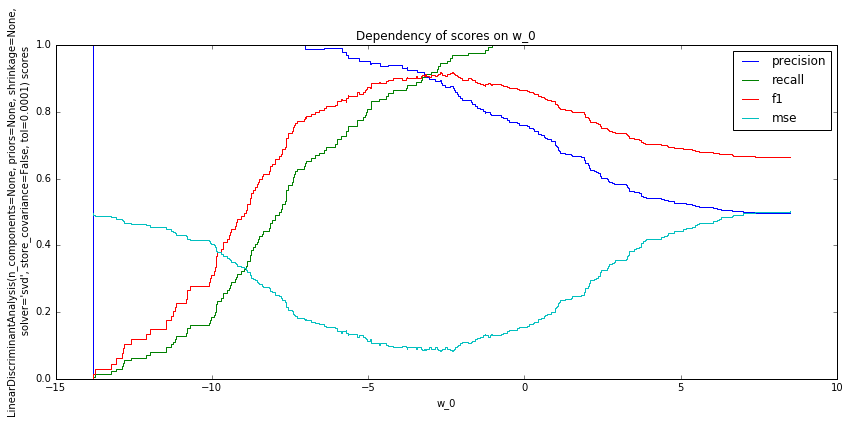

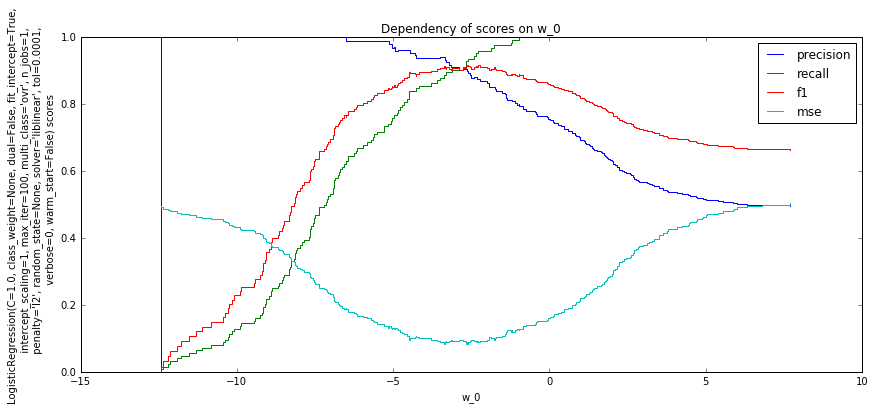

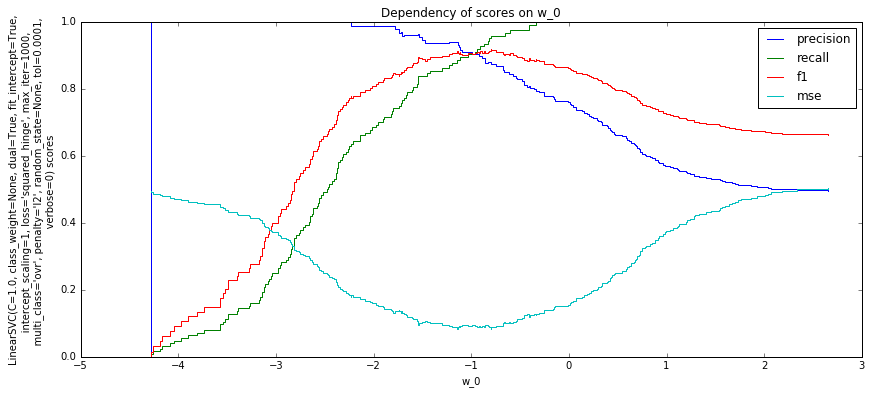

In [21]:
process_clf(lda_norm, X_test_norm, y_test_norm)
process_clf(lr_norm, X_test_norm, y_test_norm)
process_clf(svm_norm, X_test_norm, y_test_norm)

## Выводы:
Mse дискретна, потому что при монотонном увеличении $w_0$ классификация меняется не более n раз, где n — размер тестовой выборки. Она ведет себя адекватно, потому что классов всего два и каждая ошибка алгоритма карается одинаковым добавочным значением к mse (если бы классов было больше, то разные ошибки добавляли бы разное значение к итоговому mse)
Значения $w_0$ всех трех моделей близко к минимуму mse и максимуму f1, что говорит о том, что все алгоритмы хорошо настраивают этот параметр. 
presision для всех трех моделей убывает с ростом $w_0$, recall возрастает. Это связано с тем, что при маленьких $w_0$ ответы алгоритма сильнее чувствительны к изменениям < w, X_test >, алгоритм более точен.

## Пункт 2
Повторим то же самое для других выборок: с хорошо разделимыми классами и хорошо перемешанными:

Для хорошо разделимой выборки:

Сгенерируем выборку так, чтобы классы не перемешивались и разобьем на train и test в отношении 1:1

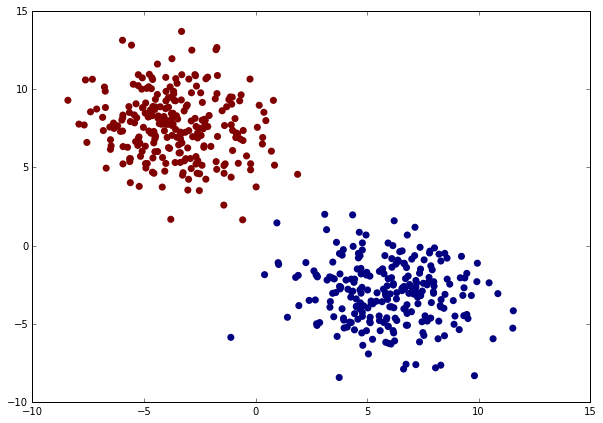

In [44]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=2)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, linewidths=0, s=50)
plt.show()

In [45]:
X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X, y, test_size=0.5, random_state=1234)

Получим w и w_0 для моделей:

In [47]:
lda_less = LinearDiscriminantAnalysis()
lr_less = LogisticRegression()
svm_less = LinearSVC()
regressions(lda_less, lr_less, svm_less, X_train_less, y_train_less)

LDA w: [[-2.26513907  2.18482463]]
LDA w_0: [-2.3920998]

LR w: [[-1.07685473  0.92874608]]
LR w_0: [-0.18160236]

SVM w: [[-0.5393878   0.42847793]]
SVM w_0: [-0.03941237]



И построим графики метрик:

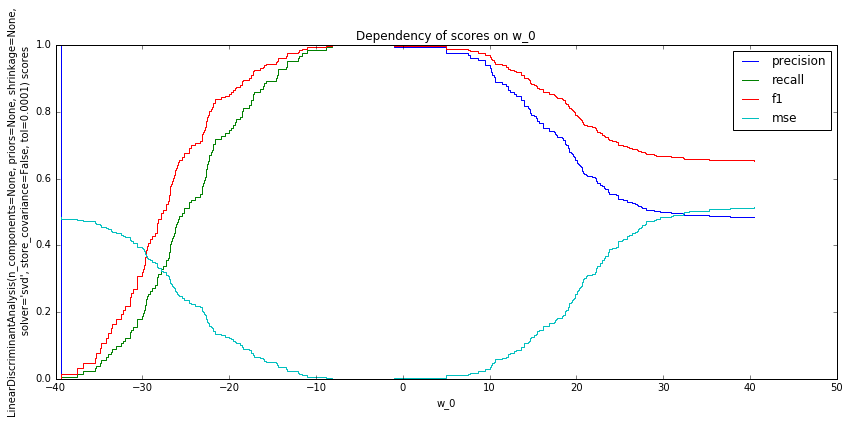

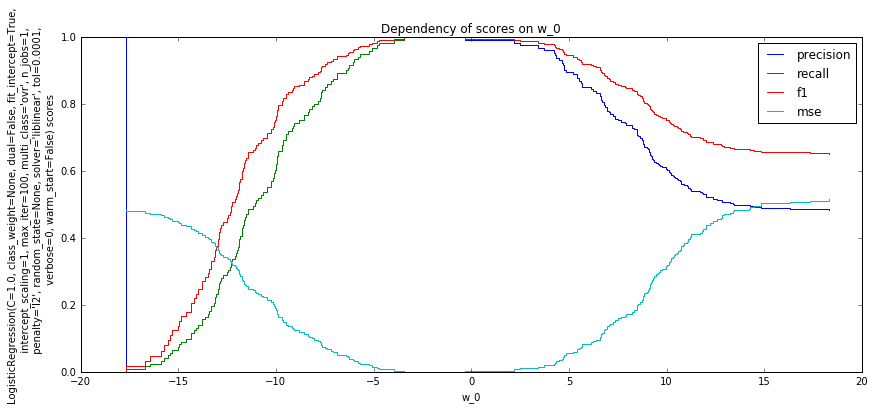

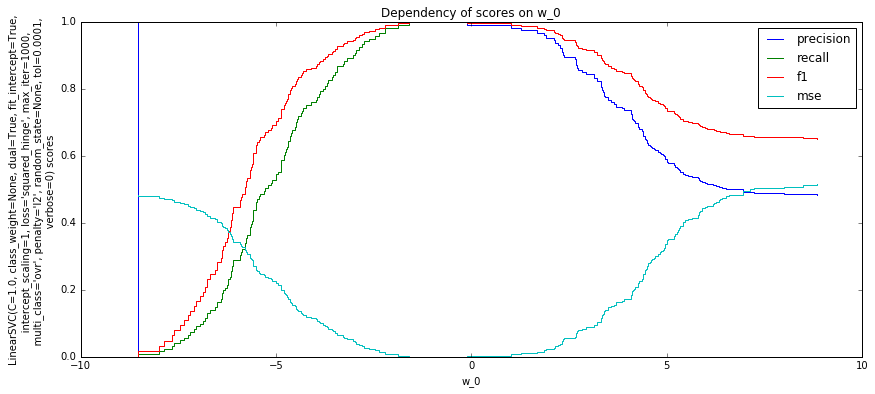

In [48]:
process_clf(lda_less, X_test_less, y_test_less)
process_clf(lr_less, X_test_less, y_test_less)
process_clf(svm_less, X_test_less, y_test_less)

И для сильно перемешанных классов:

Сгенерируем выборку так, чтобы классы сильно перемешивались и разобьем на train и test в отношении 1:1

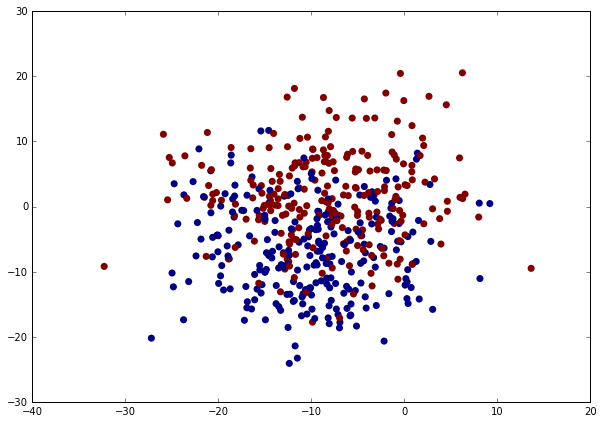

In [49]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=7)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, linewidths=0, s=50)
plt.show()

In [50]:
X_train_more, X_test_more, y_train_more, y_test_more = train_test_split(X, y, test_size=0.5, random_state=1234)

Получим w и w_0 для моделей:

In [52]:
lda_more = LinearDiscriminantAnalysis()
lr_more = LogisticRegression()
svm_more = LinearSVC()
regressions(lda_more, lr_more, svm_more, X_train_more, y_train_more)

LDA w: [[ 0.05118985  0.18226663]]
LDA w_0: [ 1.13499718]

LR w: [[ 0.04949303  0.17265233]]
LR w_0: [ 1.06448828]

SVM w: [[ 0.02152124  0.0676808 ]]
SVM w_0: [ 0.45008327]



И построим графики метрик:

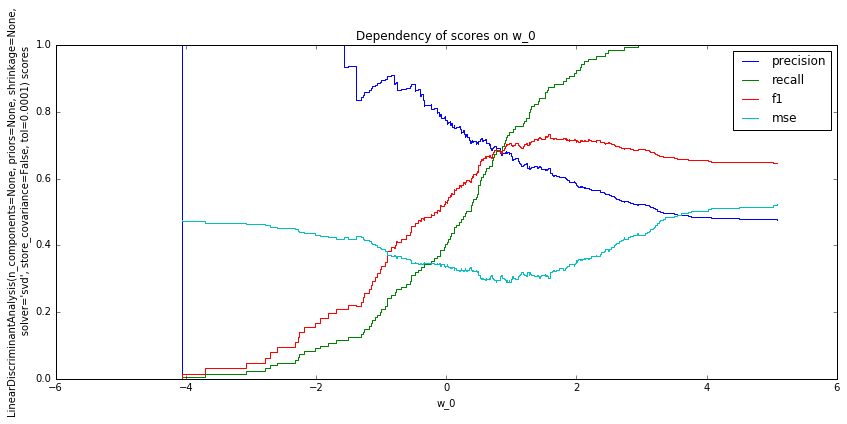

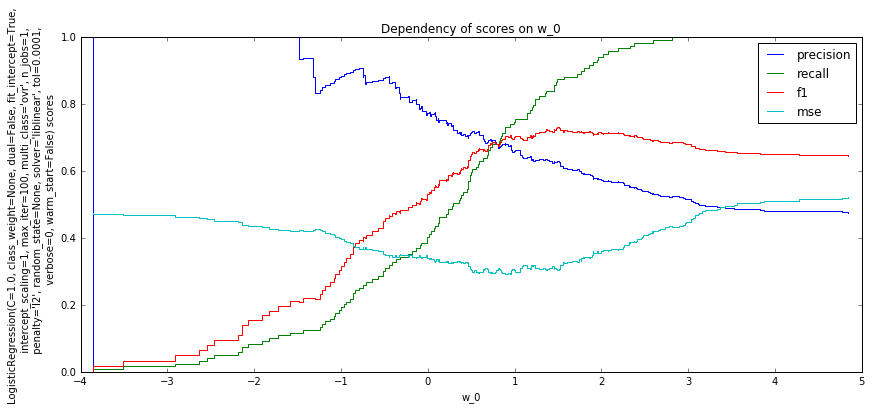

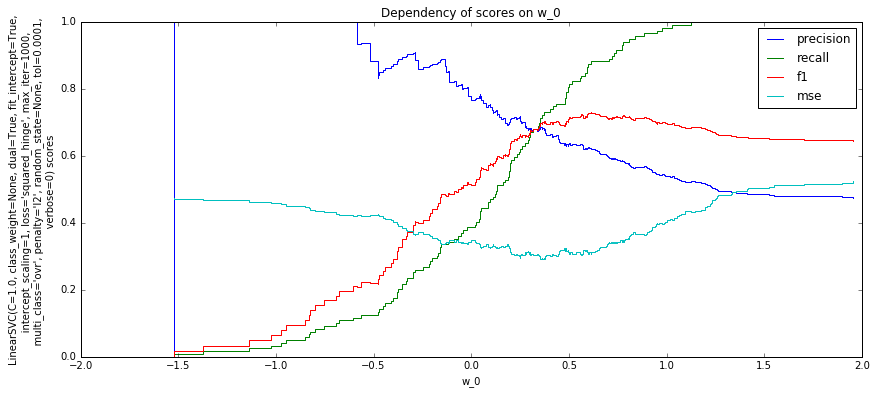

In [53]:
process_clf(lda_more, X_test_more, y_test_more)
process_clf(lr_more, X_test_more, y_test_more)
process_clf(svm_more, X_test_more, y_test_more)

## Выводы:
Все 3 алгоритма хорошо разделили выборку, классы которой были хорошо разделимы -- для всех трех график mse достигал нуля, f1 -- единицы.  Для плохо разделимой метрики mse заметно увеличилось, f1 снизилось. 
Для всех трех выборок графики алгоритмов визуально не сильно отличаются, непонятно, лучше ли какая-то из моделей. 

## Пункт 3

Посчитаем для каждой модели метрику roc-auc и построим график roc-кривой:

In [131]:
def show_roc_auc_for_clf(clf, X_test, y_test, name):
    
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

    plt.plot(fpr, tpr, label=name)
    plt.xlabel("fpr")
    plt.ylabel("tpr")

In [139]:
def show_roc_auc(X_train, y_train, X_test, y_test, data_type):
    plt.figure(figsize=(14, 6))

    lda = LinearDiscriminantAnalysis().fit(X_train, np.ravel(y_train))
    show_roc_auc_for_clf(lda, X_test, y_test, "LDA")
    
    lr = LogisticRegression().fit(X_train, np.ravel(y_train))
    show_roc_auc_for_clf(lr, X_test, y_test, "LR")
    
    svm = SVC(probability=True).fit(X_train, np.ravel(y_train))
    show_roc_auc_for_clf(svm, X_test, y_test, "SVM")
    
    plt.title("roc-auc curves for %s"%data_type)
    plt.legend(loc=1)
    plt.show()

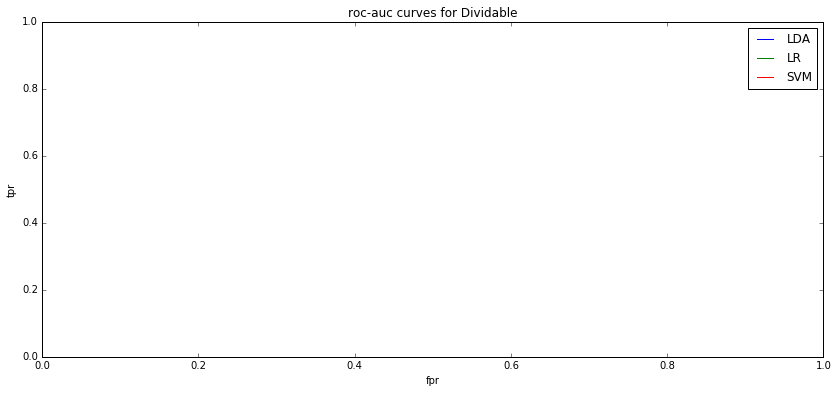

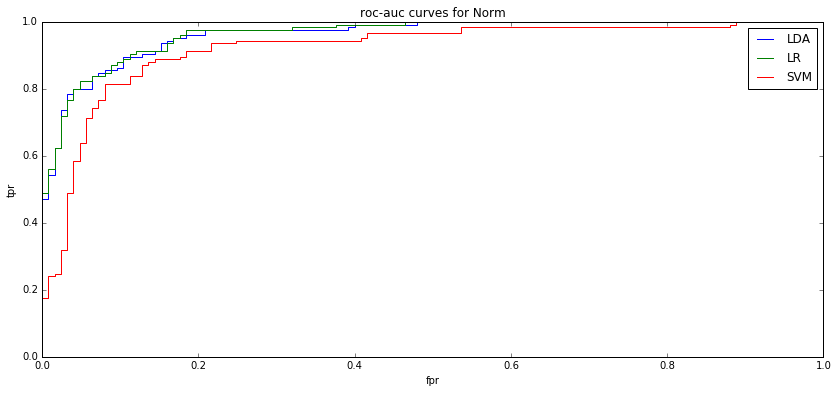

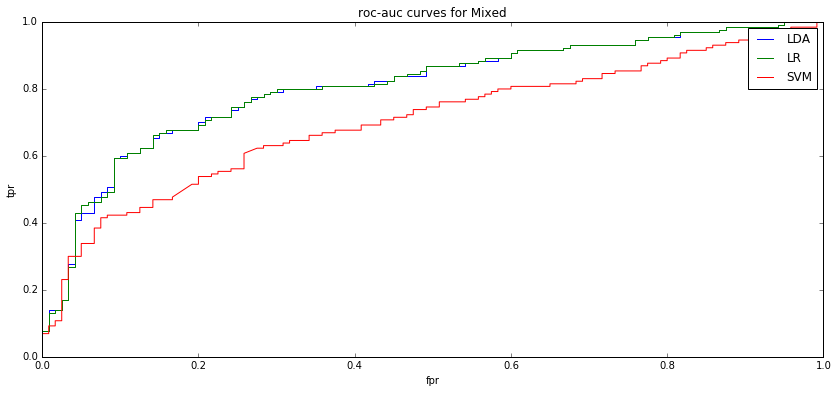

In [217]:
show_roc_auc(X_train_less, y_train_less, X_test_less, y_test_less, "Dividable")
show_roc_auc(X_train_norm, y_train_norm, X_test_norm, y_test_norm, "Norm")
show_roc_auc(X_train_more, y_train_more, X_test_more, y_test_more, "Mixed")

## Выводы:
По метрикам, исследованным в предыдущем пункте, нельзя было сказать, какой алгоритм лучше. Здесь же видно, что если классы не идеально разделимы, по auc-roc метрике SVM хуже двух других, а LDA и LR все еще практически одинаковы. Для идеально разделимых классов SVM все еще находит разделение.

## Пункт 4

Сгенерируем выборку и разобьем на train и test в отношении 1:1

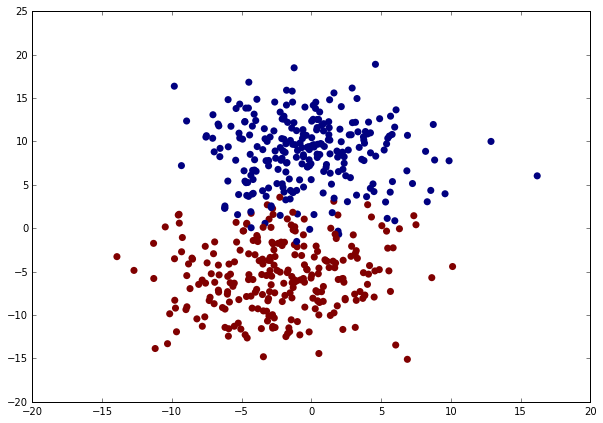

In [256]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=4)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, linewidths=0, s=50)
plt.show()

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1234)

Для некоторых значений C обучим модель на обучающей выборке и визуализируем полученную классификацию:

In [258]:
def draw_graphics(models, X, Y, figsize=(15, 7), num_col=1, support_size=300, point_size=10, margin=False):
    for i_model, model in enumerate(models):
        if i_model % num_col == 0:
            plt.figure(figsize=figsize)
        plt.subplot(1, num_col, i_model % num_col + 1)
            
        C = model.get_params()['C']
        
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                        s=np.abs(model._dual_coef_) * support_size, facecolors='none', zorder=10)
        plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, s=point_size, cmap=plt.cm.Set2)
            
        for number, support_vector in enumerate(model.support_vectors_):
            coef = model._dual_coef_[0, number]
            plt.text(support_vector[0] + 0.01, support_vector[1] + 0.01,
                     '{:.2}'.format(coef), fontsize=12,
                     bbox=dict(facecolor='r' if np.abs(coef) == C else 'w', alpha=0.6))
            
        plt.axis('tight')
        x_min = X[:, 0].min() - 0.1
        x_max = X[:, 0].max() + 0.1
        y_min = X[:, 1].min() - 0.1
        y_max = X[:, 1].max() + 0.1

        XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]
        Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])
        Z = Z.reshape(XX.shape)
        if margin:
            plt.pcolormesh(XX, YY, Z, cmap=plt.cm.RdBu)
        else:
            plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Set2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        plt.title('$C$ = {}, kernel = {}'.format(C, model.get_params()['kernel']))
        
        if (i_model + 1) % num_col == 0:
            plt.show()
    
    if (i_model + 1) % num_col != 0:
            plt.show()

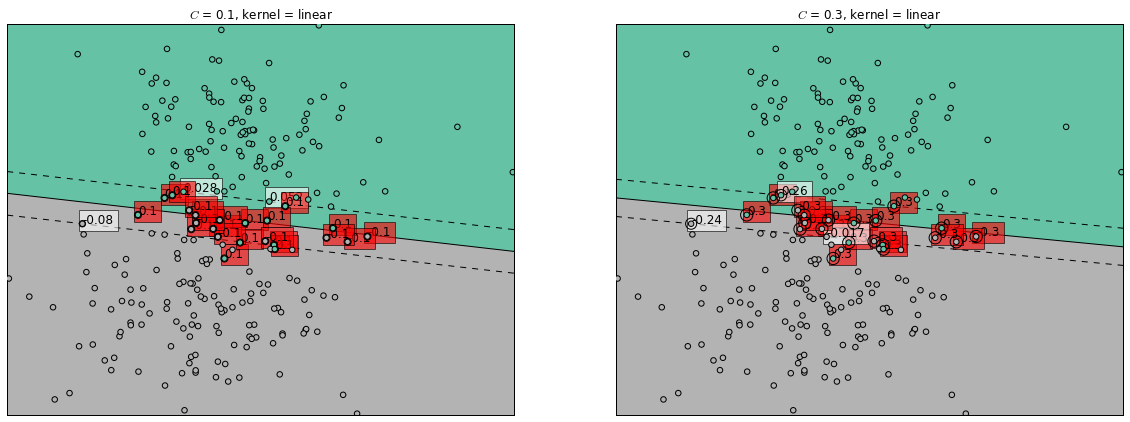

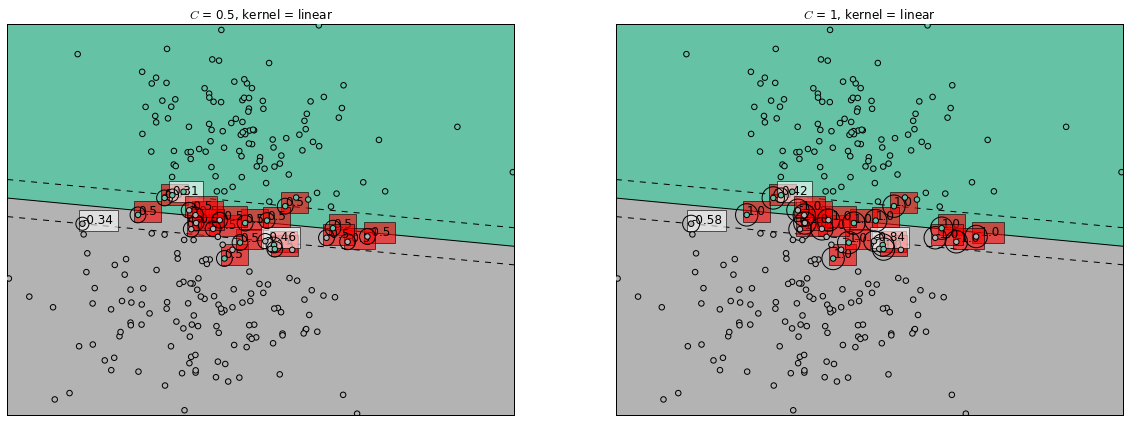

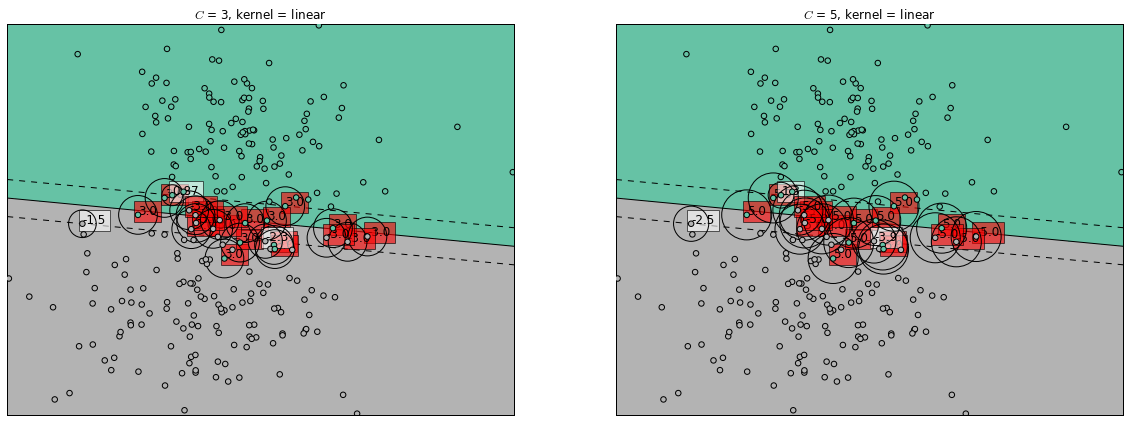

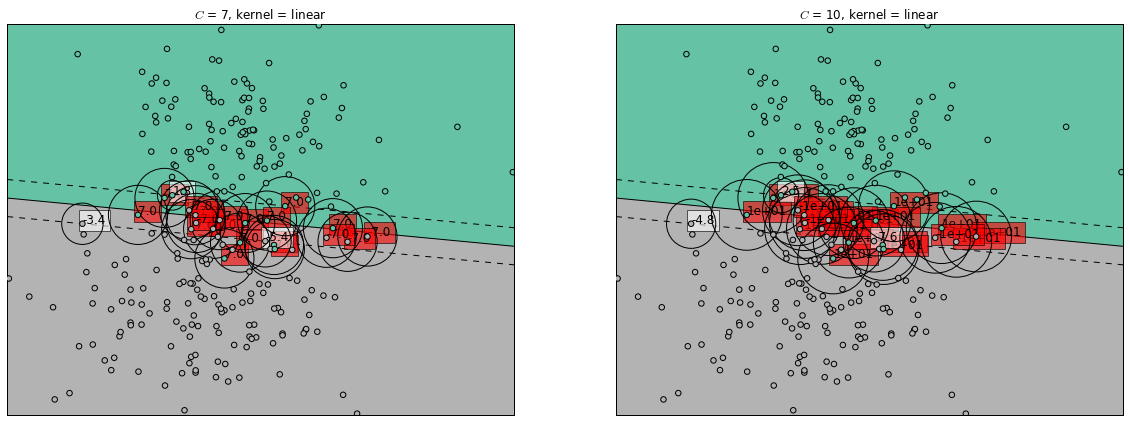

In [266]:
draw_graphics([SVC(kernel='linear', C=C).fit(X_train, y_train) for C in [0.1, 0.3, 0.5, 1, 3, 5, 7, 10]], 
              X_train, y_train, num_col=2, figsize=(20, 7), support_size=500, point_size=30)

Построим графики метрик F1 и ROC-AUC в зависимости от C на тестовой выборке:

In [267]:
f1_scores = []
roc_auc_scores = []

for C in [0.1, 0.3, 0.5, 1, 3, 5, 7, 10]:
    clf = SVC(kernel='linear', C=C, probability=True)
    clf.fit(X_train, y_train)
    
    f1_scores.append(f1_score(y_test, clf.predict(X_test)))
    roc_auc_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))    

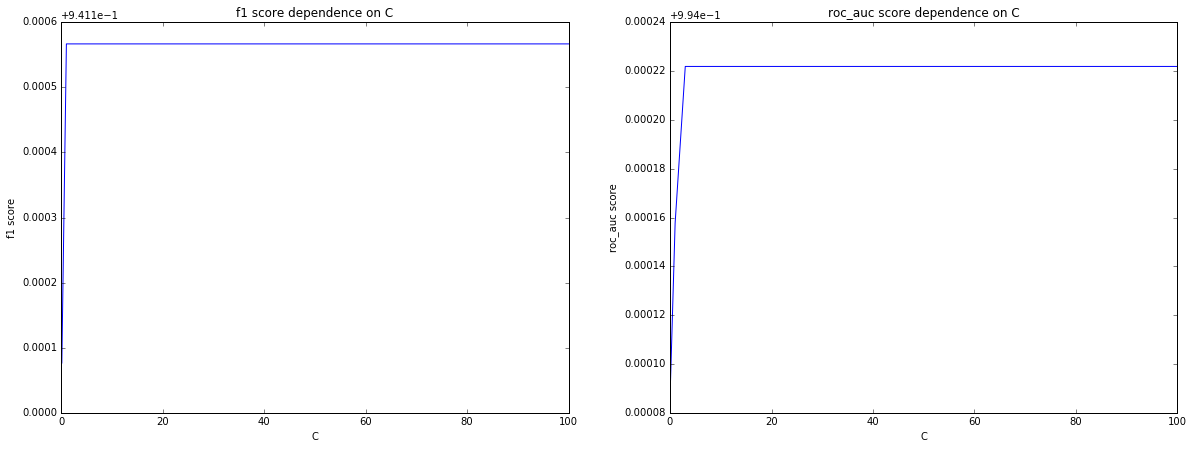

In [268]:
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.plot([0.1, 1, 3, 5, 10, 20, 50, 100], f1_scores)
plt.title("f1 score dependence on C")
plt.xlabel("C")
plt.ylabel("f1 score")

plt.subplot(1, 2, 2)
plt.plot([0.1, 1, 3, 5, 10, 20, 50, 100], roc_auc_scores)
plt.title("roc_auc score dependence on C")
plt.xlabel("C")
plt.ylabel("roc_auc score")

plt.show()

## Выводы:
Судя по графикам, параметр C не особо влияет на f1 score и yf roc-auc score результатов работы SVC

## Регрессия

Считаем данные, разобьем на train и test в отношении 3:1 и переведем в матричный вид для работы с регрессией:

In [69]:
X = pd.read_csv('data.txt', sep = ' ')
y = pd.read_csv('target.txt')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

X_train = np.matrix(X_train)
X_test = np.matrix(X_test)
y_train = np.matrix(y_train)
y_test = np.matrix(y_test)

Линейная регрессия в одну строчку:

In [70]:
y_pred = X_test * ((X_train.T * X_train).I * X_train.T * y_train)
print 'Test mse:', mean_squared_error(y_pred, y_test)

Test mse: 3273.9635968


Детерминант матрицы, которая обращается при вчислении регрессии:

In [71]:
print np.linalg.det(X_train.T * X_train)

8.92456481988e-48


Детерминант близок к нулю, поэтому результат обращения матрицы ненадежный

## Пункт 5

Обучим Ridge, LASSO и ElasticNet при разных значениях параметра alpha и построим графики mse в зависимости от alpha:

In [72]:
def show_mse(clf, log_min, log_max, num, name):
    mse_errors = []
    alpha = np.logspace(log_min, log_max, num) 
    
    for a in alpha:
        if 'l1_ratio' in clf.get_params():
            l1_ratio = clf.get_params()['l1_ratio']
            clf.set_params(alpha=0.5 * a * (1 - l1_ratio), l1_ratio=a * l1_ratio)
        else:
            clf.set_params(alpha=a)
        clf.fit(X_train, y_train)
        mse_errors.append(mean_squared_error(y_test, clf.predict(X_test)))
    
    plt.figure(figsize=(14, 6))
    plt.plot(alpha, mse_errors)
    plt.xscale('log')
    plt.axis('tight')
    plt.title(name)
    plt.xlabel('alpha')
    plt.ylabel('mse')

    plt.show()

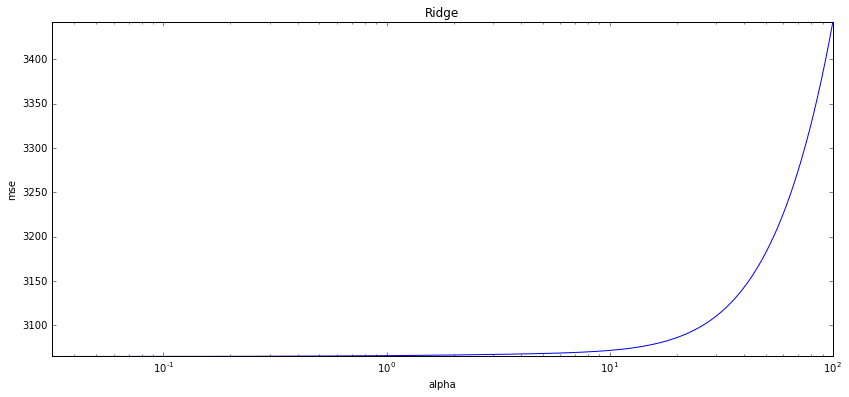

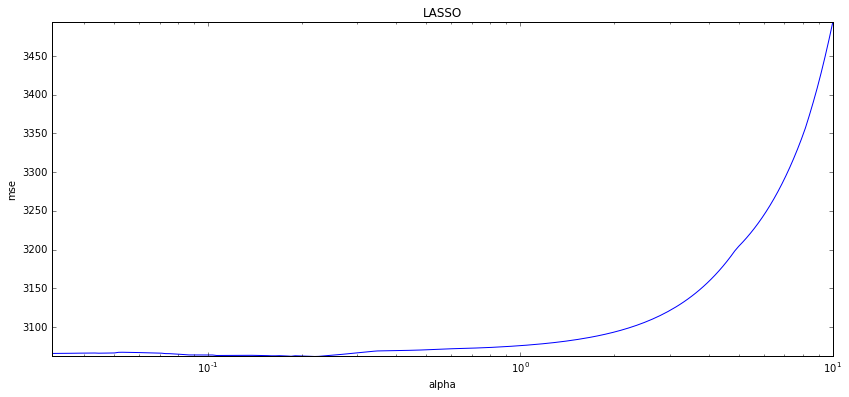

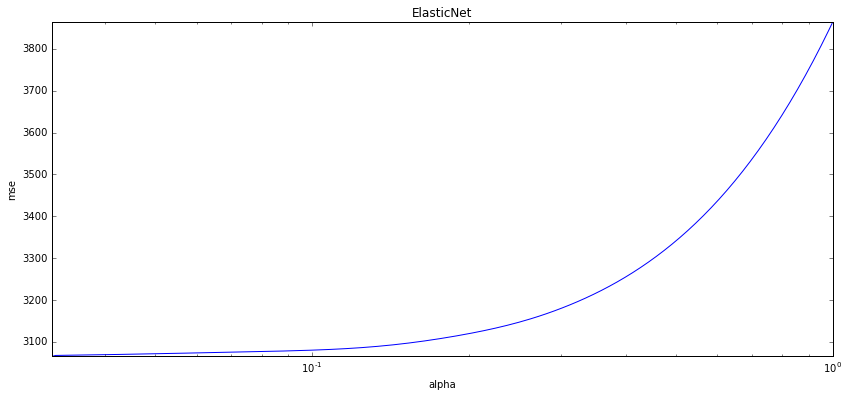

In [74]:
show_mse(Ridge(fit_intercept=False), -1.5, 2, 200, 'Ridge')
show_mse(Lasso(fit_intercept=False), -1.5, 1, 200, 'LASSO')
show_mse(ElasticNet(fit_intercept=False, l1_ratio=0.5), -1.5, 0, 200, 'ElasticNet')

Повторим то де самое для двух других разбиения на train и test выборку (с другим random state)

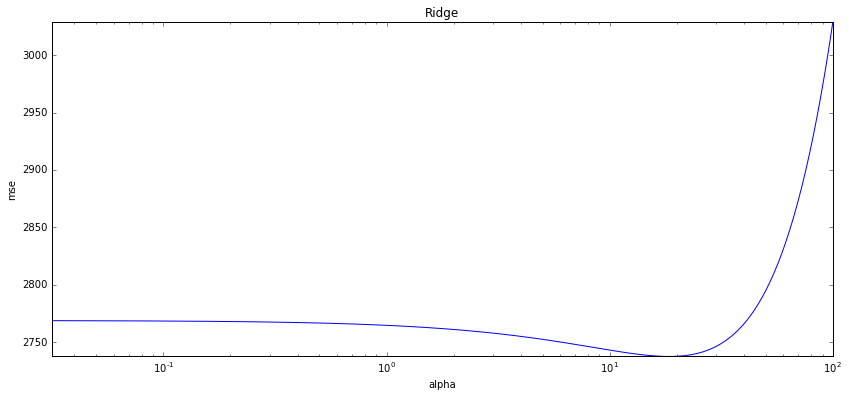

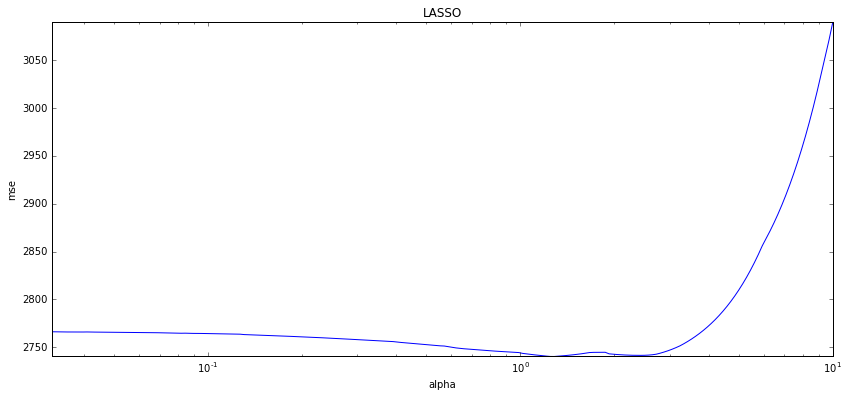

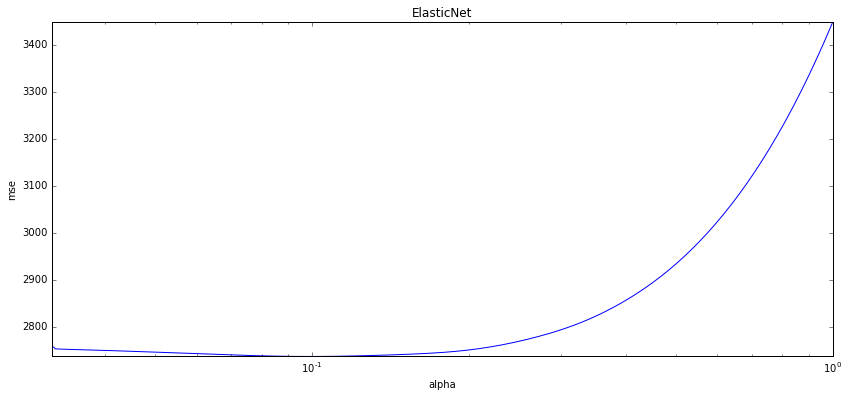

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

X_train = np.matrix(X_train)
X_test = np.matrix(X_test)
y_train = np.matrix(y_train)
y_test = np.matrix(y_test)

show_mse(Ridge(fit_intercept=False), -1.5, 2, 200, 'Ridge')
show_mse(Lasso(fit_intercept=False), -1.5, 1, 200, 'LASSO')
show_mse(ElasticNet(fit_intercept=False, l1_ratio=0.5), -1.5, 0, 200, 'ElasticNet')

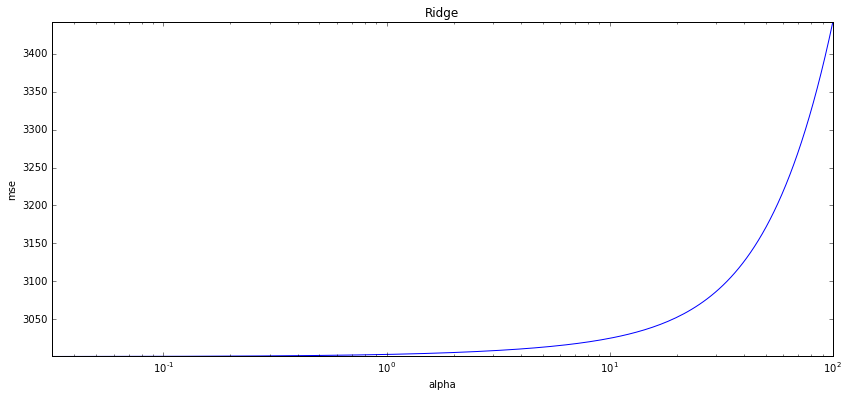

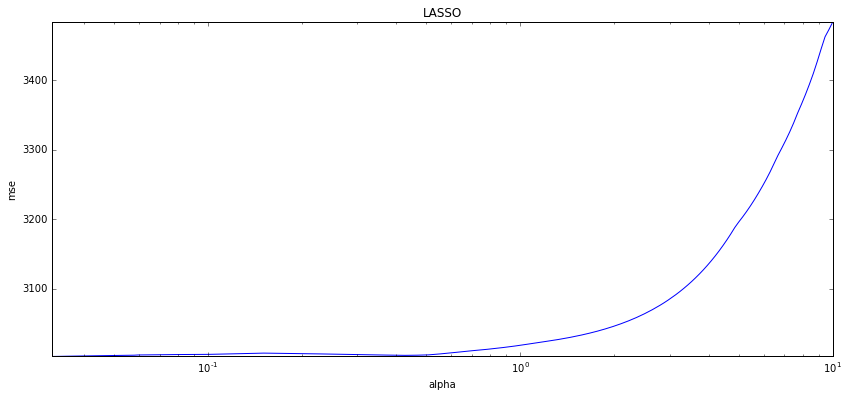

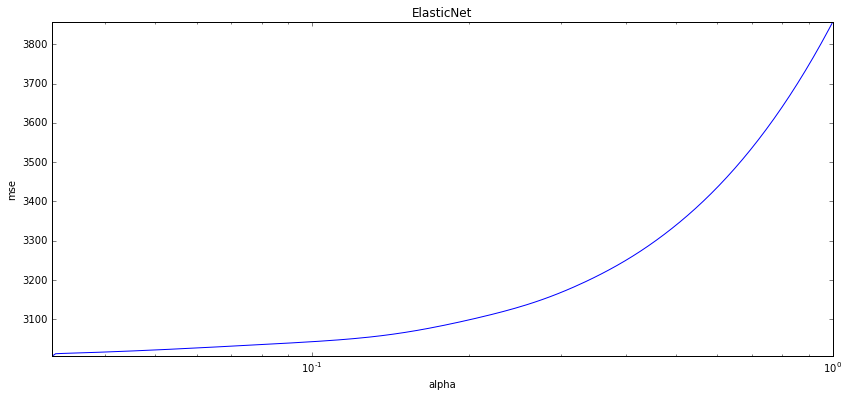

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

X_train = np.matrix(X_train)
X_test = np.matrix(X_test)
y_train = np.matrix(y_train)
y_test = np.matrix(y_test)

show_mse(Ridge(fit_intercept=False), -1.5, 2, 200, 'Ridge')
show_mse(Lasso(fit_intercept=False), -1.5, 1, 200, 'LASSO')
show_mse(ElasticNet(fit_intercept=False, l1_ratio=0.5), -1.5, 0, 200, 'ElasticNet')

## Выводы:

Для каждой из трех моделей регрессии существует деление выборки на train и test такое, что mse с ростом alpha монотонно возрастает и также существует деление выборки на train и test такое, что минимум mse достигается не при alpha=0. Это говорит о том, что для каждой выборки имеет смысл подбирать оптимальный параметр alpha для всех трех моделей.

## Пункт 6

Вернемся к начальному разбиению выборки:

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

X_train = np.matrix(X_train)
X_test = np.matrix(X_test)
y_train = np.matrix(y_train)
y_test = np.matrix(y_test)

Для Ridge и LASSO построим графики траекторий путей весов признаков:

In [97]:
def draw_track(clf, log_min, log_max, num, name):
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        clf.set_params(alpha=a)
        clf.fit(X_train, y_train)
        coefs.append(clf.coef_.ravel())

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ax.plot(alphas, coefs, linewidth=2)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title(name)
    plt.axis('tight')
    plt.show()

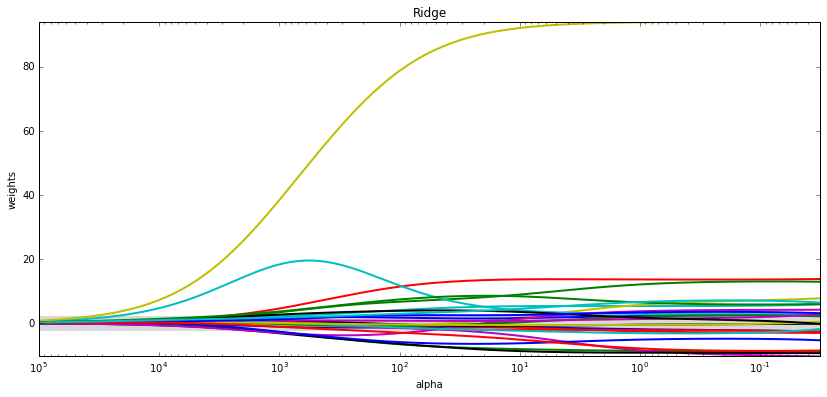

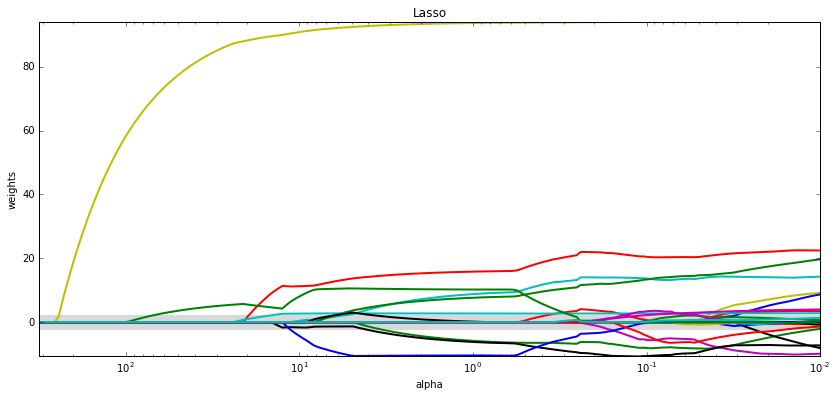

In [98]:
draw_track(Ridge(fit_intercept=False), -1.5, 5, 200, 'Ridge')
draw_track(Lasso(fit_intercept=False), -2, 2.5, 200, 'Lasso')

## Выводы:

Для обеих регрессий один из признаков имеет намного больший вес, чем остальные. При этом все остальные не сильно отличаются между собой по важности как для Rdge, так и для LASSO

## Пункт 7

SVM-регрессия использует epsilon-insensitive функцию потерь. Напишем ее:

In [162]:
def svr_loss_function(y_pred, y_test, eps):
    error = 0
    for i in range(len(y_test)):
        error += max(0, abs(y_test[i] - y_pred[i]) - eps)
    return float(error)/len(y_test)

Будем исследовать SVR для следующих значений C и eps:

In [237]:
C = np.logspace(-2, 2, 10)
EPS = np.logspace(-2, 2, 10)

In [238]:
C

array([  1.00000000e-02,   2.78255940e-02,   7.74263683e-02,
         2.15443469e-01,   5.99484250e-01,   1.66810054e+00,
         4.64158883e+00,   1.29154967e+01,   3.59381366e+01,
         1.00000000e+02])

In [239]:
mse_errors = []
svr_loss_errors = []
for c in C:
    mse_errors_C = []
    svr_loss_errors_C = []
    for eps in EPS:
        clf = SVR(C=c, epsilon=eps, kernel='linear')
        clf.fit(X_train, np.ravel(np.array(y_train)))
        
        mse_errors_C.append(mean_squared_error(clf.predict(X_test), y_test))
        svr_loss_errors_C.append(svr_loss_function(clf.predict(X_test), y_test, eps))
        
    mse_errors.append(mse_errors_C)
    svr_loss_errors.append(svr_loss_errors_C)

In [240]:
pd.DataFrame.from_records(mse_errors)

,0,1,2,3,4,5,6,7,8,9
0,4700.286351,4700.265627,4700.212611,4698.558331,4693.280262,4683.137863,4677.006433,4669.305155,4740.607758,5473.968463
1,4189.689609,4189.630401,4189.467626,4189.030008,4188.625861,4190.491575,4208.227241,4226.436048,4305.434097,5048.933539
2,3632.117894,3631.837824,3631.061245,3628.925130,3627.435429,3613.817998,3594.623123,3628.182965,3719.431511,4766.693572
3,3169.757800,3169.811070,3169.975768,3171.706805,3171.396323,3169.443631,3157.945002,3170.129710,3258.207720,4377.211979
4,3072.949622,3072.948455,3072.682956,3072.905236,3070.676624,3088.607410,3065.417449,3050.996964,3037.973688,4041.033910
5,3108.768871,3108.470135,3107.645832,3107.664448,3101.931402,3116.660519,3145.694061,3095.417278,2980.361283,3718.401171
6,3253.868833,3254.033422,3254.496451,3255.821040,3253.354679,3216.978804,3159.609064,3105.300115,3012.263777,3440.443966
7,3303.346185,3303.730065,3304.869496,3308.198549,3313.428451,3292.321951,3229.031186,3091.261632,3017.484638,3505.465562
8,3280.344370,3280.371837,3280.506998,3281.129094,3287.482715,3306.801903,3225.370436,3094.155515,3030.285552,3541.944663
9,3279.260701,3280.971348,3285.809873,3299.842920,3296.750459,3324.071229,3218.247462,3093.097757,3017.082335,3610.348096


In [241]:
pd.DataFrame.from_records(svr_loss_errors)

,0,1,2,3,4,5,6,7,8,9
0,56.132456,56.117544,56.076050,55.953160,55.606412,54.512351,51.554972,43.932137,26.832067,3.876319
1,52.895757,52.879452,52.834083,52.707840,52.382023,51.396092,48.548794,41.282268,24.275549,3.139957
2,49.461846,49.443543,49.392608,49.252775,48.870762,47.796526,44.840195,37.389089,21.210124,2.641733
3,45.837130,45.817117,45.761498,45.618791,45.203094,44.095759,41.280892,33.891913,18.754406,2.159527
4,44.602459,44.583774,44.530008,44.387660,44.011526,43.108336,39.894610,32.588768,17.325028,1.843950
5,44.440125,44.420030,44.364114,44.217459,43.782027,42.776821,40.138694,32.489346,16.757063,1.481827
6,45.353983,45.336570,45.288140,45.153373,44.727893,43.346850,40.076226,32.467278,16.888534,1.457826
7,45.576348,45.562029,45.522449,45.412050,45.069317,43.852926,40.485047,32.297953,16.886743,1.572351
8,45.361087,45.342707,45.291656,45.151038,44.803068,43.866979,40.410996,32.243355,16.939874,1.618866
9,45.337321,45.326411,45.296649,45.226909,44.844140,43.980807,40.336695,32.199211,16.848901,1.778895


Для default значения С построим графики mse и svr функции потерь от eps:

In [242]:
def show_errors_on_eps(C=1.0):
    plt.figure(figsize=(20, 7))

    mse_train = []
    mse_test = []
    for eps in EPS:
        clf = SVR(epsilon=eps, C=C, kernel='linear').fit(X_train, np.ravel(np.array(y_train)))
        mse_train.append(mean_squared_error(y_train, clf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, clf.predict(X_test)))

    plt.subplot(1, 2, 1)
    plt.plot(EPS, mse_train, label="train")
    plt.plot(EPS, mse_test, label="test")
    plt.title("mse errors dependence on eps with default C")
    plt.xlabel("eps")
    plt.ylabel("mse errors")

    plt.legend(loc=1)

    svr_loss_train = []
    svr_loss_test = []
    for eps in EPS:
        clf = SVR(epsilon=eps, C=C, kernel='linear').fit(X_train, np.array(y_train).ravel())
        svr_loss_train.append(svr_loss_function(clf.predict(X_train), y_train, eps))
        svr_loss_test.append(svr_loss_function(clf.predict(X_test), y_test, eps))

    plt.subplot(1, 2, 2)
    plt.plot(EPS, svr_loss_train, label="train")
    plt.plot(EPS, svr_loss_test, label="test")
    plt.title("svr errors dependence on eps with default C")
    plt.xlabel("eps")
    plt.ylabel("svr errors")

    plt.legend(loc=1)

    plt.show()

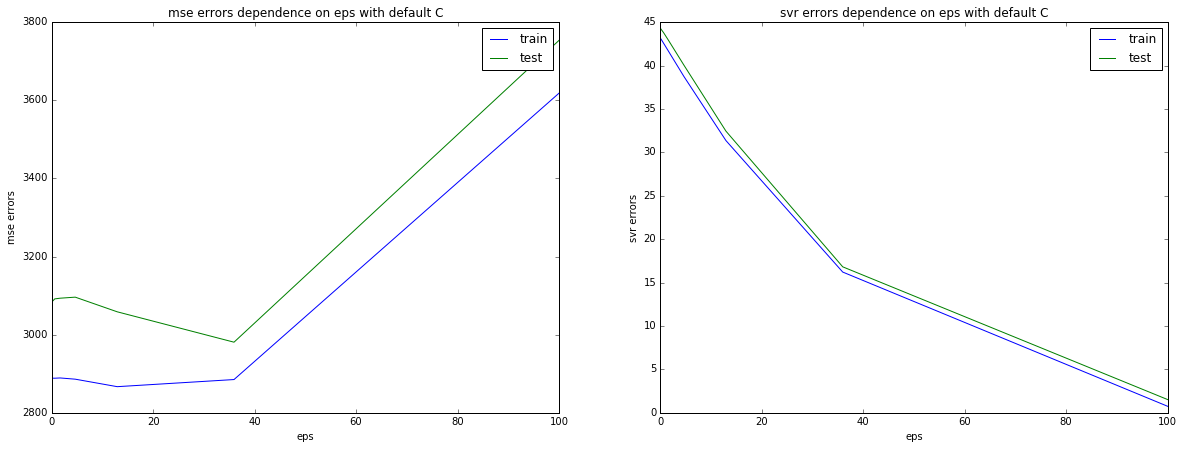

In [243]:
show_errors_on_eps()

Для default значения eps построим графики mse и svr функции потерь от С:

In [244]:
def show_errors_on_C(eps=0.1):
    plt.figure(figsize=(20, 7))

    mse_train = []
    mse_test = []
    for c in C:
        clf = SVR(epsilon=eps, C=c, kernel='linear').fit(X_train, np.ravel(np.array(y_train)))
        mse_train.append(mean_squared_error(y_train, clf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, clf.predict(X_test)))

    plt.subplot(1, 2, 1)
    plt.plot(C, mse_train, label="train")
    plt.plot(C, mse_test, label="test")
    plt.title("mse errors dependence on C with default eps")
    plt.xlabel("C")
    plt.ylabel("mse errors")

    plt.legend(loc=1)

    svr_loss_train = []
    svr_loss_test = []
    for c in C:
        clf = SVR(epsilon=eps, C=c, kernel='linear').fit(X_train, np.array(y_train).ravel())
        svr_loss_train.append(svr_loss_function(clf.predict(X_train), y_train, eps))
        svr_loss_test.append(svr_loss_function(clf.predict(X_test), y_test, eps))

    plt.subplot(1, 2, 2)
    plt.plot(C, svr_loss_train, label="train")
    plt.plot(C, svr_loss_test, label="test")
    plt.title("svr errors dependence on C with default eps")
    plt.xlabel("C")
    plt.ylabel("svr errors")

    plt.legend(loc=1)

    plt.show()

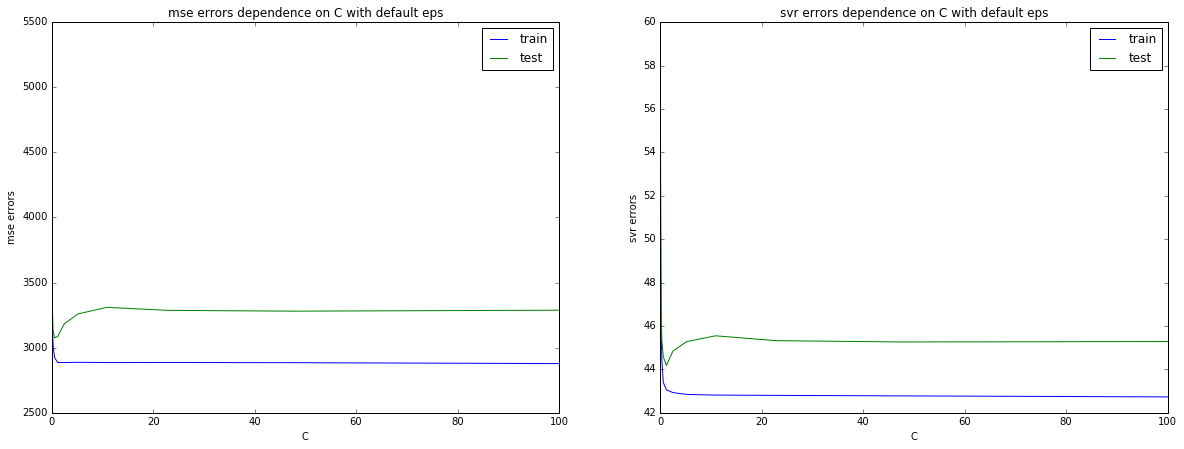

In [229]:
show_errors_on_C()

Визуализируем графики mse и svr функции потерь от С и от eps также для двух значений eps и С из сетки:

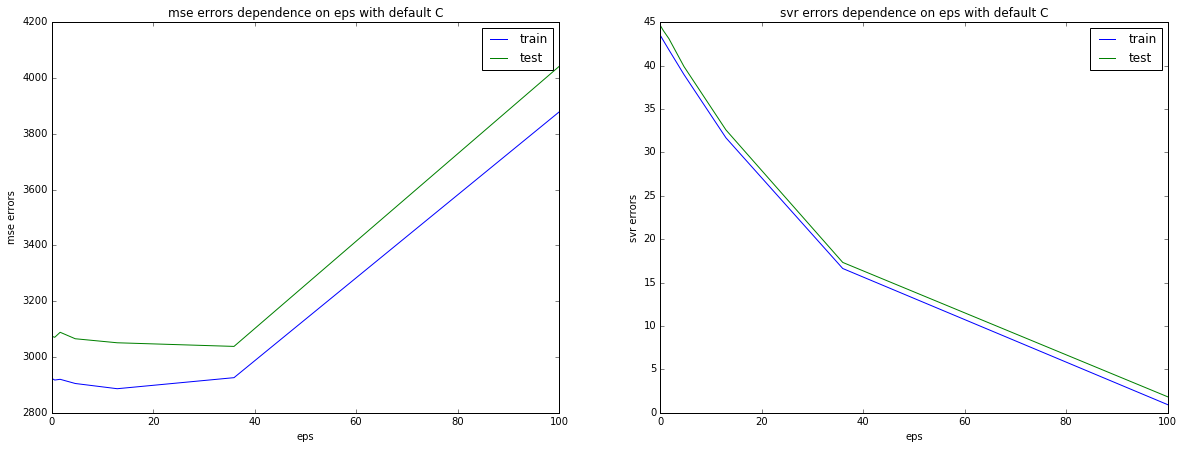

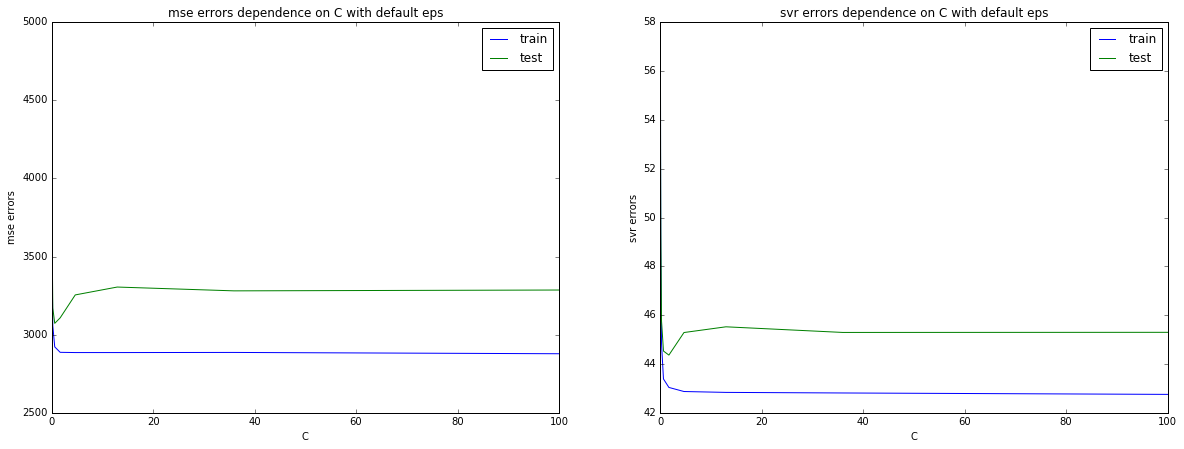

In [245]:
show_errors_on_eps(C=5.99484250e-01)
show_errors_on_C(eps=7.74263683e-02)

Качественно графики такие же, как для default C и eps.

## Выводы:
Из матриц ошибок видно, что при маленьких и очень больших C значения mse и ошибки SVR обе большие. Значит, оптимальное С должно быть не совсем маленьким. Однако по матрицам ошибок непонятно, какие точно значения eps и C оптимальны, это зависит во многом от того, какую из функций потерь хочется мzинимизировать -- это же видно по графику mse и svr функции потерь от eps при default C. По графикам mse и svr функции потерь от С при default eps также можно сказать, что С должен быть небольшим, так как для default eps с ростом С обе ошибки неубывают.